# Overview of `eolearn.core`

`eolearn.core` is the main subpackage which implements basic building blocks (`EOPatch`, `EOTask` and `EOWorkflow`) and commonly used functionalities.

## EOPatch

EOPatch is common data-object that contains contains multi-temporal remotely sensed data of a single patch (area) of Earth’s surface typically defined by a bounding box in specific coordinate reference system.

There’s no limitation on the amount of data, or the type of data that can be stored. But typically, all of the information is internally stored in form of NumPy arrays as the following features:

- DATA with shape t x n x m x d: time- and position-dependent remote sensing data (e.g. bands) of type float
- MASK with shape t x n x m x d: time- and position-dependent mask (e.g. ground truth, cloud/shadow mask,
super pixel identifier) of type int
- SCALAR with shape t x s: time-dependent and position-independent remote sensing data (e.g. weather data,) of type
float
- LABEL with shape t x s: time-dependent and position-independent label (e.g. ground truth) of type int
- VECTOR: a list of time-dependent vector shapes in shapely.geometry classes
- DATA_TIMELESS with shape n x m x d: time-independent and position-dependent remote sensing data (e.g.
elevation model) of type float
- MASK_TIMELESS with shape n x m x d: time-independent and position-dependent mask (e.g. ground truth,
region of interest mask) of type int
- SCALAR_TIMELESS with shape s:  time-independent and position-independent remote sensing data of type float
- LABEL_TIMELESS with shape s: time-independent and position-independent label of type int
- VECTOR_TIMELESS: time-independent vector shapes in shapely.geometry classes
- META_INFO: dictionary of additional info (e.g. resolution, time difference)
- BBOX: bounding box of the patch which is an instance of sentinelhub.BBox
- TIMESTAMP: list of dates which are instances of datetime.datetime

Create an empty patch

In [1]:
from eolearn.core import EOPatch

patch = EOPatch()

Set a feature to EOPatch

In [2]:
from eolearn.core import FeatureType
import numpy as np

new_bands = np.zeros((5, 10, 10, 13), dtype=np.float32)

patch[FeatureType.DATA]['bands'] = new_bands
# or patch.data['bands'] = new_bands

Display a string representation of EOPatch (using repr method)

In [3]:
patch

EOPatch(
  data: {
    bands: <class 'numpy.ndarray'>, shape=(5, 10, 10, 13), dtype=float32
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {}
  bbox: None
  timestamp: []
)

Get all non-empty features of EOPatch

In [4]:
patch.get_features()

{<FeatureType.DATA: 'data'>: {'bands'}}

Get a feature from EOPatch

In [5]:
patch[FeatureType.DATA]['bands'];
# or patch.data['bands']

Save EOPatch

In [6]:
patch.save('./example_patch')

Load EOPatch

In [7]:
patch2 = EOPatch.load('./example_patch')

Compare EOPatches

In [8]:
patch == patch2

True

Remove a feature from EOPatch

In [9]:
del patch2[FeatureType.DATA]['bands']
# or del patch.data['bands']

Make a shallow and deep copy of EOPatch

In [10]:
patch1 = patch.__copy__()
patch2 = patch.__deepcopy__()

In [11]:
patch == patch1

True

In [12]:
patch == patch2

True

Concatenate two EOPatches

In [13]:
patch2[FeatureType.DATA]['bands2'] = new_bands

patch + patch2
# or EOPatch.concatenate(patch, patch2)

EOPatch(
  data: {
    bands: <class 'numpy.ndarray'>, shape=(10, 10, 10, 13), dtype=float32
    bands2: <class 'numpy.ndarray'>, shape=(5, 10, 10, 13), dtype=float32
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {}
  bbox: None
  timestamp: []
)

## EOTask

An EO task is any class the inherits from the abstract EOTask class. Each EO task has to implement the execute method; invoking __call__ on a EO task instance invokes the execute method. EO tasks are meant primarily to operate on EO patches (i.e. instances of EOPatch).

Add a feature using the EOTask

In [14]:
from eolearn.core import AddFeature

patch = EOPatch()

feature = (FeatureType.DATA, 'bands')
add_feature = AddFeature(feature)

data = np.zeros((5, 100, 100, 13))
patch = add_feature.execute(patch, data)
# or patch = add_feature(patch, data)

patch

EOPatch(
  data: {
    bands: <class 'numpy.ndarray'>, shape=(5, 100, 100, 13), dtype=float64
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {}
  bbox: None
  timestamp: []
)

Create a composite task using a multiplication operator (`a * b`) function

In [15]:
from eolearn.core import CopyTask, RenameFeature

copy_task = CopyTask()
rename_feature = RenameFeature((FeatureType.DATA, 'bands', 'the_bands'))
copy_rename_task = rename_feature * copy_task
new_patch = copy_rename_task(patch)

new_patch

EOPatch(
  data: {
    the_bands: <class 'numpy.ndarray'>, shape=(5, 100, 100, 13), dtype=float64
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {}
  bbox: None
  timestamp: []
)

If a task doesn’t exist yet, the user can implement it and easily include it into his/hers workflow. There is very little or almost no overhead in the implementation of a new EOTask as seen from this minimal example

In [16]:
from eolearn.core import EOTask

class FooTask(EOTask):
    def __init__(self, foo_param):
        self.foo_param = foo_param

    def execute(self, eopatch, *, patch_specific_param):
        # do what foo does on input eopatch and return it
        return eopatch

EOTask’s arguments are either static (set when EOTask is initialized; i.e.e foo_param above) or dynamic (set during the execution of the workflow; i.e. patch_specific_param above).

The list of all EOTasks in the `eolearn.core` subpackage is available here https://eo-learn.readthedocs.io/en/latest/eotasks.html#core

## EOWorkflow

A workflow is a directed (acyclic) graph composed of instances of EOTask objects. Each task may take as input the results of other tasks and external arguments. The external arguments are passed anew each time the workflow is executed. The workflow builds the computational graph, performs dependency resolution, and executes the tasks. If the input graph is cyclic, the workflow raises a CyclicDependencyError.

The result of a workflow execution is an immutable mapping from tasks to results. The result contains tasks with zero out-degree (i.e. terminal tasks).

Create a workflow

In [17]:
from eolearn.core import EOWorkflow, Dependency

workflow = EOWorkflow(dependencies=[
    Dependency(transform=add_feature, inputs=[]),
    Dependency(transform=copy_task, inputs=[add_feature]),
    Dependency(transform=rename_feature, inputs=[copy_task])]
)
                                    
result = workflow.execute({
    add_feature: {'eopatch': patch,
                  'data': new_bands}
})
                                    
result

WorkflowResults(
  Dependency(RenameFeature): EOPatch(
  data: {
    the_bands: <class 'numpy.ndarray'>, shape=(5, 10, 10, 13), dtype=float32
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {}
  bbox: None
  timestamp: []
)
)

Display the dependency graph

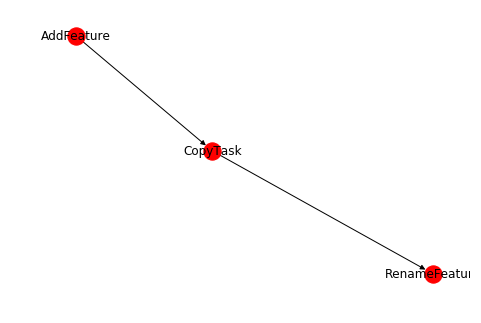

In [18]:
%matplotlib inline

workflow.dependency_graph('graph.png', view=True)

For a linear workflow such as previous one you can use `EOWorkflow.make_linear_workflow` function

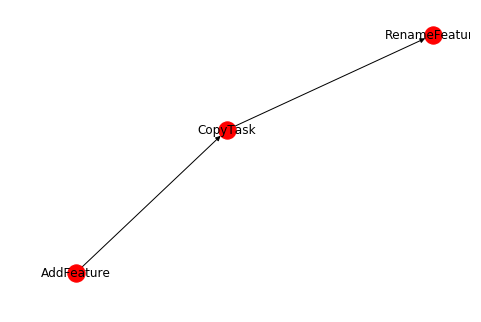

In [19]:
workflow = EOWorkflow.make_linear_workflow(add_feature, copy_task, rename_feature)

result = workflow.execute({
    add_feature: {'eopatch': patch,
                  'data': new_bands}
})
                                    
workflow.dependency_graph('graph.png', view=True)

## EOExecutor

EOExecutor handles execution and monitoring of workflows. It enables executing a workflow multiple times and in parallel. It monitors execution times and handles any error that might occur in the process. At the end it generates a report which contains summary of the workflow and process of execution.

Execute previously defined workflow with different arguments

In [20]:
from eolearn.core import EOExecutor

execution_args = [
    {add_feature: {'eopatch': patch,
                  'data': new_bands}},
    {add_feature: {'eopatch': patch,
                  'data': new_bands - 1}},
    {add_feature: {'eopatch': patch,
                  'data': new_bands * 10}},
]

executor = EOExecutor(workflow, execution_args)

executor.run()

Make the report

In [21]:
# disable plotting
%matplotlib
%matplotlib

html_report = executor.make_report()

Using matplotlib backend: TkAgg
Using matplotlib backend: TkAgg


Display the report inside the notebook

In [22]:
from IPython.core.display import display, HTML

# display(HTML(html_report))